In [1]:
import numpy as np
import time
import pickle
from scipy import misc
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# matplotlib.use('Qt5Agg')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
#import cvxpy as cp
from scipy.optimize import fsolve
from IPython.display import Markdown
torch.set_default_dtype(torch.float64)

# Parameters of the model

In [78]:
M=1000
ite=10
dim_n=3
T=1
delta = torch.tensor(T/ite)
#delta=torch.tensor(0.01)
sigma=0.2
mu=0.3
A0=0.0
gamma=0.0
kappa=1
rho=5
X0=10000
neuron_model_psi=16
print(delta)

tensor(0.1000)


In [91]:
params = {'M':1000,
        'num_time_steps':10,
        'dim':3, #dimension
        'T':1,# terminal time
        'sigma':0.2,
        'mu':0.3,
        'A0':0.0, #initial fundamental price
        'gamma':0.0, # permanent price impact
        'kappa':0.1,#price impact coeff
        'rho':5,#resillience
        'init_balance':10000,
        'num_neurons':16}

# Closed-form solution


In [92]:
def closed_form(X):
  alpa=np.exp(-rho*T/ite)
  p=np.zeros(ite+1)
  p[0]=X/((ite-1)*(1-alpa)+2)
  p[ite]=X/((ite-1)*(1-alpa)+2)
  for j in range(1,ite):
    p[j]=p[0]*(1-alpa)
  return p


In [93]:
class solution(object):
    def __init__(self,params):
        self.ite = params['num_time_steps']
        self.T = params['T']
        self.rho = params['rho']
        self.kappa = params['kappa']
        self.delta = self.T/self.ite
        self.alpha=np.exp(-self.rho*self.delta)
    def optimal(self,x_init):
        t = torch.tensor([i*self.delta for i in range(self.ite+1)])
        for i in range(x_init.shape[0]):
            if i==0:
                trade = ((1-(torch.where(t==0.0*self.delta,0,1)*torch.where(t==self.ite*self.delta,0,1))*self.alpha)*x_init[i]/((self.ite-1)*(1-self.alpha)+2)).unsqueeze(0)
            else:
                trade = torch.cat((trade,((1-(torch.where(t==0.0*self.delta,0,1)*torch.where(t==self.ite*self.delta,0,1))*self.alpha)*x_init[i]/((self.ite-1)*(1-self.alpha)+2)).unsqueeze(0)),axis=0)
        return trade
    def __call__(self, x):
        exec =  self.optimal(x)   
        c_tmp = torch.tensor([0.0])
        D_tmp = torch.tensor([0.0])
        for i in range(self.ite+1):
            c_tmp = c_tmp + D_tmp*exec[:,i]+(self.kappa/2.0)*np.power(exec[:,i],2)
            D_tmp = (D_tmp + self.kappa * exec[:,i])*self.alpha
        return c_tmp

In [94]:
cf = solution(params)
test_input = X0*0.9+(X0*1.1-X0*0.9)*torch.rand(M,1)
cf.optimal(test_input).shape,cf(test_input).shape,test_input.shape

(torch.Size([1000, 11]), torch.Size([1000]), torch.Size([1000, 1]))

# Deep approximation

In [95]:
model= torch.nn.Sequential(
    torch.nn.Linear(dim_n, neuron_model_psi),
    torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi, neuron_model_psi),
    torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi,1)
)

In [96]:
# model=torch.load('model_N100_T1_K1_rho5_neo50.pth')

# Definition of update, unit, and loss

In [97]:
class trade_net(nn.Module): #NN for trading strategy
    def __init__(self,params):
        self.dim = params['dim']
        self.num_neurons = params['num_neurons']
        super(trade_net, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(self.dim, self.num_neurons),
            torch.nn.ReLU(),
            nn.Linear(self.num_neurons, self.num_neurons),
            torch.nn.ReLU(),
            nn.Linear(self.num_neurons,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])       

In [98]:
class value_fnc(nn.Module): #NN for trading strategy
    def __init__(self,params):
        self.dim = params['dim']
        self.num_neurons = params['num_neurons']
        super(value_fnc, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(self.dim, self.num_neurons),
            torch.nn.ReLU(),
            nn.Linear(self.num_neurons, self.num_neurons),
            torch.nn.ReLU(),
            nn.Linear(self.num_neurons,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])       

In [99]:
class optimal_execution(object):
    def __init__(self,params):
        self.epoch = 0
        self.loss_epoch=[]
        self.M = params['M']
        self.ite = params['num_time_steps']
        self.dim = params['dim']
        self.T = params['T']
        self.sigma = params['sigma']
        self.mu = params['mu']
        self.A0 = params['A0'] #initial fundamental price
        self.gamma = params['gamma'] # permanent price impact
        self.kappa = params['kappa'] #price impact coeff
        self.rho = params['rho'] #resillience
        self.X0 = params['init_balance']
        # self.neuron_model_psi = params['num_neurons']
        self.delta = self.T/self.ite
        self.alpha=np.exp(-self.rho*self.delta)
        self.trade_size = trade_net(params)
        self.V = value_fnc(params)
        t=torch.zeros([self.M,1])
        D=torch.zeros([self.M,1])
        R=self.X0*0.9+(self.X0*1.1-self.X0*0.9)*torch.rand(self.M,1)  #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
        self.x=torch.cat((t,D,R),dim=1)
        self.trained = False
        self.exit_dict = params # Write the result in this dict
        self.cf = solution(params)#closed-form solution

        
    def update(self,x,psi):
        t=(x[:,0]+self.delta)
        D = (x[:,1]+self.kappa*psi)*self.alpha
        R= x[:,2]-psi
        up=torch.cat((t.unsqueeze(1),D.unsqueeze(1),R.unsqueeze(1)),dim=1)
        return up
    
    def step_cost(self,x,psi):
        loss=(x[:,1]*psi+(self.kappa/2.0)*torch.pow(psi,2))
        return loss
    
    def unit(self,x):
        psi=self.trade_size(x).squeeze(1)
        loss=self.step_cost(x,psi)
        upd=self.update(x,psi)
        return psi, loss, upd
    
    def cost(self,x):
        cost=torch.zeros(self.M,self.ite+1)
        psi=torch.zeros(self.M,self.ite)
        u=x
        for i in range(self.ite+1):
            if(i!=self.ite):
                psi_run,loss_run,u_run=self.unit(u)
                #print('los func=',psi_run.shape,loss_run.shape)
                cost[:,i]=loss_run
                #print(loss)
                psi[:,i]=psi_run
                #print(psi)
                u=u_run
                #print(u)
            else:
                # print(torch.sum(psi,dim=1).shape,x[:,2].shape)
                # psi_ter=x[:,2]-torch.sum(psi,dim=1)
                # psi_ter = u[:,2]
                cost[:,i]=self.step_cost(u,u[:,2])
                #print('ter',loss_ter.shape)
        cost=torch.sum(cost,dim=1)
        #print(loss.shape)
        return cost
    
    def train(self, lr, err, num_epochs):
        start=time.time()
        # lr = 8e-3
        epoch=self.epoch
        # num_epochs=500
        L_=-1000
        optimizer = optim.Adam(self.trade_size.parameters(), lr)
        L=100000
        while (np.abs(L_-L)/np.abs(L_)>err) &  (epoch <= num_epochs):
            t0 = time.time()
            optimizer.zero_grad()
            cost=self.cost(self.x)
            loss = torch.mean(cost)
            loss.backward()
            optimizer.step()
            L = loss.clone().detach().numpy()
            self.loss_epoch.append(L)
            if epoch>0:
                L_ = self.loss_epoch[epoch-1]
            if (epoch % int(num_epochs/5)== int(num_epochs/5)-1) | (epoch == 0):
                print("At epoch {:,} the mean cost is {:.10E}.  Epoch training time = {:.2E} ms".format(epoch+1,loss.detach(),1000*(time.time()-t0)))            
            epoch=epoch+1
        end=time.time()
        print('time elapsed = {:.2e} ms'.format((end-start)*1000))
        print("Relative change in loss = %{:.7E} , last epoch = {}.".format((100*np.abs(L_-L)/np.abs(L_)),epoch+1))
        
        self.epoch = epoch
        self.exit_dict['loss_log'] = self.loss_epoch
        self.exit_dict['last_epoch'] = epoch-1
        self.exit_dict['relative change in loss'] = (np.abs(L_-L)/np.abs(L_))
        self.exit_dict['execution_time'] = (end-start)*1000
        
        self.trained = True
        self.exit_dict['optimal_strategy'] = self.trade_size
        self.value()#  Must be after the line above.
        self.exit_dict['data'] = [self.x_data,self.y_data]#  Must be after the line above.
        self.exit_dict['value'] = self.V
        #testing
        t=torch.zeros([self.M,1])
        D=torch.zeros([self.M,1])
        test_init = self.X0*0.9+(self.X0*1.1-self.X0*0.9)*torch.rand(self.M,1)
        x_test=torch.cat((t,D,test_init),dim=1)
        L1_rel_err = torch.mean(torch.abs(self.cf(test_init)-self.cost(x_test).squeeze(-1)))/torch.mean(torch.abs(self.cf(test_init)))*100
        L_inf_err = torch.max(torch.abs(self.cf(test_init)-self.cost(x_test).squeeze(-1)))
        self.exit_dict['sup_error'] = L_inf_err
        self.exit_dict['rel_L1_error'] = L1_rel_err
        
    def gen_data(self):
        if self.trained:
            cost=torch.zeros(self.M,self.ite+1)
            psi=torch.zeros(self.M,self.ite)
            u=self.x
            self.x_data = u
            for i in range(self.ite+1):
                if(i!=self.ite):
                    if i >0:
                        self.x_data = torch.cat((self.x_data,u),axis=0)
                    psi_run,loss_run,u_run=self.unit(u) 
                    #print('los func=',psi_run.shape,loss_run.shape)
                    cost[:,i]=loss_run
                    #print(loss)
                    psi[:,i]=psi_run
                    #print(psi)
                    u=u_run
                    #print(u)
                else:
                    # print(torch.sum(psi,dim=1).shape,x[:,2].shape)
                    # psi_ter=self.x[:,2]-torch.sum(psi,dim=1)
                    cost[:,i]=self.step_cost(u,u[:,2])
                    self.x_data = torch.cat((self.x_data,u),axis=0)
                    #print('ter',loss_ter.shape)
            self.y_data=torch.sum(cost,dim=1).unsqueeze(-1)
            for i in range(self.ite):
                self.y_data = torch.cat((self.y_data,torch.sum(cost[:,i+1:],dim=1).unsqueeze(-1)),axis=0)
            r = torch.randperm(self.x_data.shape[0])
            self.x_data = self.x_data[r,:].clone().detach()
            self.y_data = self.y_data[r,:].clone().detach()       
        else:
            self.train(8e-3,1e-7,3000)
            self.gen_data()
        
    def value(self):
        self.gen_data()
        start=time.time()
        lr = 8e-3
        num_batches = 4
        epoch=0
        loss_epoch = []
        num_epochs=2000
        L_=torch.tensor([-1000])
        loss = torch.tensor([1000])
        optimizer = optim.Adam(self.V.parameters(), lr)
        err = 1e-6
        mse = nn.MSELoss()
        batch_size = int(self.x_data.shape[0]/num_batches)
        batch_epochs = int(num_epochs/num_batches)
        b=0
        print("Building value functin...")
        # while i < num_batches:
        while (torch.abs(L_-loss)/torch.abs(L_)>err) &  (epoch <= num_epochs):
            t0 = time.time()
            optimizer.zero_grad()
            index = [b*batch_size, self.x_data.shape[0]] if (b+1==num_batches) else [b*batch_size, (b+1)*batch_size]
            loss = mse(self.V(self.x_data[index[0]:index[1],:]),self.y_data[index[0]:index[1],:])
            loss.backward()
            optimizer.step()
            loss_epoch.append(loss)
            if epoch>0:
                L_ = loss_epoch[epoch-1]
            # if (epoch % int(num_epochs/5)== int(num_epochs/5)-1) | (epoch == 0):
            #     print("At epoch {:,} mse in approximating the value function is {:.10E}.  Epoch training time = {:.2E} ms".format(epoch+1,loss.detach(),1000*(time.time()-t0)))
            epoch=epoch+1
            if epoch == (b+1)*batch_epochs:
                print("At epoch {:,} batch {} is used.".format(epoch+1,b+2))
            if epoch >= (b+1)*batch_epochs:
                b = b + 1
        end=time.time()
        print('time elapsed = {:.2e} ms'.format((end-start)*1000))
        print("Relative change in mse of the value function is %{:.7E}.".format((100*torch.abs(L_-loss)/torch.abs(L_)).item()))
        
        
    def __call__(self,x_init):
        t = torch.tensor([i*self.delta for i in range(self.ite+1)])
        for i in range(x_init.shape[0]):
            if i==0:
                trade = ((1-(torch.where(t==0.0*self.delta,0,1)*torch.where(t==self.ite*self.delta,0,1))*self.alpha)*x_init[i]/((self.ite-1)*(1-self.alpha)+2)).unsqueeze(0)
            else:
                trade = torch.cat((trade,((1-(torch.where(t==0.0*self.delta,0,1)*torch.where(t==self.ite*self.delta,0,1))*self.alpha)*x_init[i]/((self.ite-1)*(1-self.alpha)+2)).unsqueeze(0)),axis=0)
        return trade    
                

In [100]:
oe = optimal_execution(params)

In [101]:
oe.train(8e-3,1e-9,3000)

At epoch 1 the mean cost is 3.5687332763E+06.  Epoch training time = 5.39E+00 ms
At epoch 600 the mean cost is 1.4966783387E+06.  Epoch training time = 4.08E+00 ms
At epoch 1,200 the mean cost is 1.4935709827E+06.  Epoch training time = 4.17E+00 ms
time elapsed = 7.32e+03 ms
Relative change in loss = %6.6413352E-08 , last epoch = 1619.
Building value functin...
At epoch 501 batch 2 is used.
At epoch 1,001 batch 3 is used.
At epoch 1,501 batch 4 is used.
At epoch 2,001 batch 5 is used.
time elapsed = 1.82e+04 ms
Relative change in mse of the value function is %NAN.


In [102]:
# oe.gen_data()
# oe.y_data.shape,oe.x_data.shape

In [103]:
oe.value()

Building value functin...


At epoch 501 batch 2 is used.
time elapsed = 5.24e+03 ms
Relative change in mse of the value function is %3.0053435E-06.


## Comparison to closed-form solution

In [104]:
t=torch.zeros([oe.M,1])
D=torch.zeros([oe.M,1])
test_init = oe.X0*0.9+(oe.X0*1.1-oe.X0*0.9)*torch.rand(oe.M,1)
x_test=torch.cat((t,D,test_init),dim=1)
rel_err = torch.mean(torch.abs(cf(test_init)-oe.cost(x_test).squeeze(-1)))/torch.mean(torch.abs(cf(test_init)))*100
err = torch.max(torch.abs(cf(test_init)-oe.cost(x_test).squeeze(-1)))#/torch.mean(torch.abs(cf(test_init)))*100

In [105]:
Markdown(r"The $L^1$-norm of relative error of the deep learning algorithm compared to closed-form solution is %{:.2E}.".format(oe.exit_dict['rel_L1_error'].item()))

The $L^1$-norm of relative error of the deep learning algorithm compared to closed-form solution is %2.49E+00.

In [106]:
Markdown(r"The $L^\infty$-norm error of the deep learning algorithm compared to closed-form solution is \${:,.2f}.".format(oe.exit_dict['sup_error'].item()))

The $L^\infty$-norm error of the deep learning algorithm compared to closed-form solution is \$43,796.26.

In [107]:
Markdown(r"The average closed-form trading cost is \${:,.2f}.".format(torch.mean(cf(test_init)).item()))

The average closed-form trading cost is \$1,454,375.74.

In [108]:
ts = time.strftime("%Y-%m-%d-%H-%M-%S")
with open('exit_dict_'+ts+'.pkl', 'wb') as f:
    pickle.dump(oe.exit_dict, f)

In [109]:
with open('exit_dict_'+ts+'.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [110]:
loaded_dict['value'].eval()(oe.x_data)

tensor([[ 558590.6764],
        [1006111.2276],
        [ 970130.6131],
        ...,
        [ 437313.3453],
        [1161939.1864],
        [ 367217.7264]], grad_fn=<AddmmBackward0>)

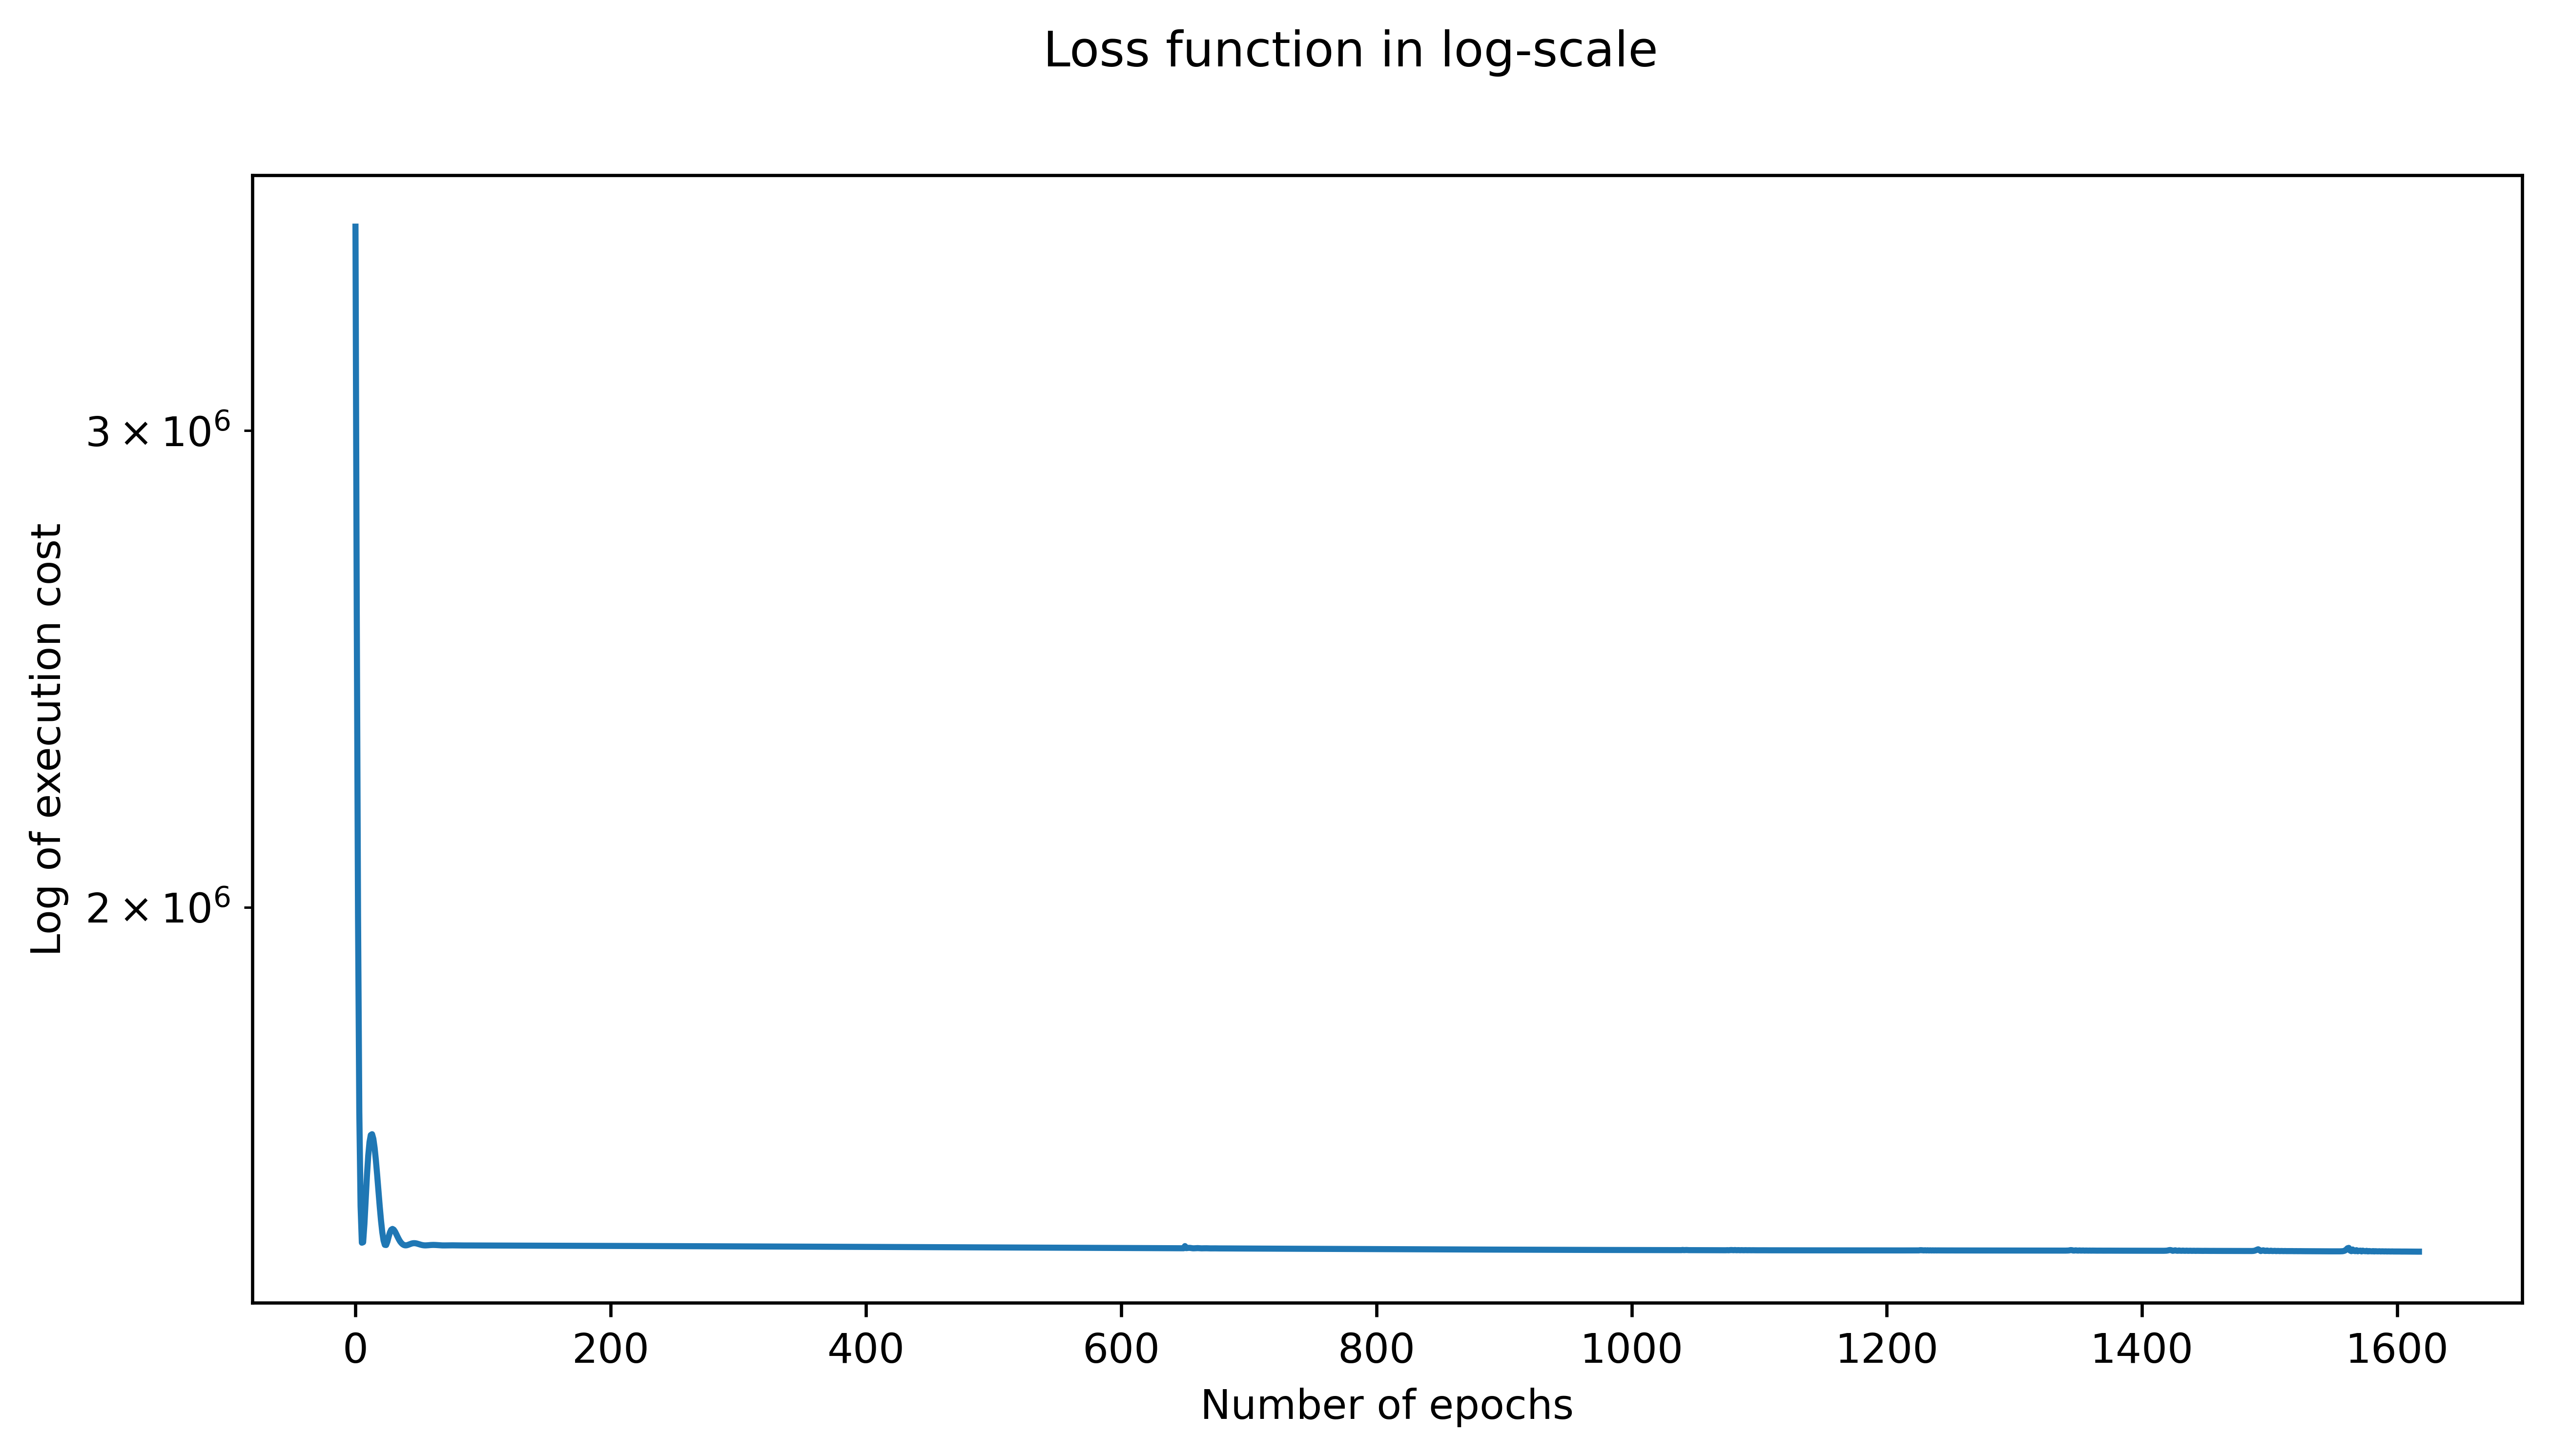

In [124]:
fig = plt.figure(figsize=(10,5),dpi=600)
ax = fig.add_subplot(1, 1, 1)    
ax.plot(loaded_dict['loss_log'])
ax.set_yscale('log')
fig.suptitle("Loss function in log-scale")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Log of execution cost");

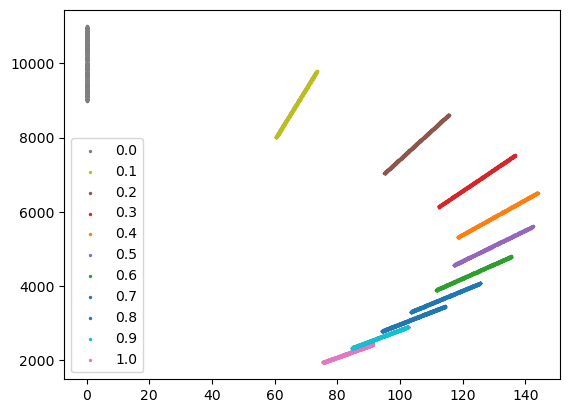

In [149]:
for n in set(list(oe.x_data[:,0].numpy())):
    x, y = oe.x_data[oe.x_data[:,0] == n][:,1].clone().detach().numpy(),oe.x_data[oe.x_data[:,0] == n][:,2].clone().detach().numpy()
    plt.scatter(x,y,label="{:.2}".format(np.round(n,1)), s=2);
handles, labels = plt.gca().get_legend_handles_labels()
handles, labels = zip(*[ (handles[i], labels[i]) for i in sorted(range(len(handles)), key=lambda k: list(map(str,labels))[k])] )
plt.legend(handles, labels, loc=0);
# plt.legend();

{0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7,
 0.7999999999999999,
 0.8999999999999999,
 0.9999999999999999}

In [114]:
PATH = 'model_N10_Arash.pth'
PATHV = 'model_N10_Arash_value.pth'
torch.save(oe.trade_size, PATH)
torch.save(oe.V, PATHV)

In [115]:
model_scripted = torch.jit.script(oe.trade_size) # Export to TorchScript
model_scripted.save('model_N10_Arash.pt') # Save
model = torch.jit.load('model_N10_Arash.pt')
model.eval()(x_test).shape
model_scripted = torch.jit.script(oe.V) # Export to TorchScript
model_scripted.save('model_N10_Arash_value.pt') # Save
model = torch.jit.load('model_N10_Arash_value.pt')
model.eval()(x_test).shape

torch.Size([1000, 1])

In [116]:
model = trade_net(params)
torch.load(PATH)
model.eval()(x_test).shape

torch.Size([1000, 1])

In [117]:
Stop here

SyntaxError: invalid syntax (594711963.py, line 1)

In [ ]:
def update(x3,psi):
  t=(x3[:,0]+delta)
  #print(psi.squeeze(1).shape,x1[:,1].shape)
  D = (x3[:,1]+kappa*psi)*torch.exp(-rho*delta)
  R= x3[:,2]-psi
  #print(R.shape)
  up=torch.cat((t.unsqueeze(1),D.unsqueeze(1),R.unsqueeze(1)),dim=1)
  #print('up shape=', up.shape)
  return up

def loss_func(x2,psi):
  loss=(x2[:,1]*psi+(kappa/2.0)*torch.pow(psi,2))
  return loss

def unit(x1,model):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi)
    #print('unit print=',psi.shape,los.shape,upd.shape)
    return psi,los,upd

def loss_func_total(u,model):
  loss=torch.zeros(M,ite)
  psi=torch.zeros(M,ite)
  for i in range(ite+1):
    if(i!=ite):
      psi_run,loss_run,u_run=unit(u,model)
      #print('los func=',psi_run.shape,loss_run.shape)
      loss[:,i]=loss_run
      #print(loss)
      psi[:,i]=psi_run
      #print(psi)
      u=u_run
      #print(u)
    else:
      #print(torch.sum(psi,dim=1),R.squeeze(1))
      psi_ter=R.squeeze(1)-torch.sum(psi,dim=1)
      loss_ter=loss_func(u,psi_ter)
      #print('ter',loss_ter.shape)
  #print(torch.sum(loss,dim=1))
  loss=torch.sum(loss,dim=1)+loss_ter
  #print(loss.shape)
  return torch.mean(loss)

Training

In [ ]:
start=time.time()
lr1 = 8e-3
epoch=0
num_epochs=500
loss_epoch=[]
L_=torch.tensor([-1000])
optimizer = optim.Adam(model.parameters(), lr1)
cost=torch.tensor([100000])
err=1e-10
#print(psi.shape)
while (torch.abs(L_-cost)/torch.abs(L_)>err) &  (epoch <= num_epochs):
  t0 = time.time()
  optimizer.zero_grad()
  cost=loss_func_total(x,model)
  cost.backward()
  optimizer.step()
  loss_epoch.append(cost)
  if epoch>0:
    L_ = loss_epoch[epoch-1]
  #print(cost,L_.item())
  if (epoch % int(num_epochs/5)== int(num_epochs/5)-1) | (epoch == 0):
    print("At epoch {} the mean cost is {:.10E}.  Epoch training time = {:.2E} ms".format(epoch,cost.detach(),1000*(time.time()-t0)))
  if (torch.abs(L_-cost)/torch.abs(L_)<=err):
    print("Delta Loss = {} , epoch = {}.".format(torch.abs(L_-cost)/torch.abs(L_),epoch))
  
  epoch=epoch+1

end=time.time()
print('time elapsed=',end-start)

At epoch 0 the mean cost is 1.8365294150E+08.  Eproch training time = 8.80E+00 ms
At epoch 99 the mean cost is 1.5047374066E+07.  Eproch training time = 6.58E+00 ms
At epoch 199 the mean cost is 1.5006421235E+07.  Eproch training time = 5.57E+00 ms
At epoch 299 the mean cost is 1.4962913509E+07.  Eproch training time = 5.21E+00 ms
At epoch 399 the mean cost is 1.4908183564E+07.  Eproch training time = 6.14E+00 ms
At epoch 499 the mean cost is 1.4838963947E+07.  Eproch training time = 5.40E+00 ms
time elapsed= 3.008842945098877


In [ ]:
# start=time.time()
# lr1 = 8e-3
# max_epoch = 12000
# optimizer = optim.Adam(model.parameters(), lr1)
# cost_ar=[]
# #print(psi.shape)
# for epoch in range(max_epoch):
#   optimizer.zero_grad()
#   cost=loss_func_total(x,model)
#   cost.backward()
#   optimizer.step()
#   cost_ar.append(cost)
#   #print(loss.item())
#   if (epoch % 100==0):
#     print("At epoch {} the mean cost is {}.".format(epoch,cost.detach()))
# end=time.time()
# total_time=end-start
# print('time elapsed=',total_time)

In [ ]:
# #time step vs training time plot
# x=np.array([10,30,50,100]) #time steps
# y=np.array([119,440,677,1356])#training times
# plt.plot(x,y)
# plt.show()

Solution by using cvxpy package

In [ ]:
# def numeric_soln(X,n):
#     delt=T/n
#     alpa=math.exp(-delt*rho)
#     c=np.ones(n)
#     x=cp.Variable(n)
#     #objective=cp.Minimize(determinstic_main(x))
#     A=[[0 for i in range(n)] for j in range(n)]
#     for i in range(n):
#         for j in range(n):
#             A[i][j]=1-kappa+kappa*pow(alpa,abs(i-j))
#     constraints=[0<=x,sum(x)==X]

#     objective=cp.Minimize(1/2*cp.quad_form(x,A))
#     prob=cp.Problem(objective,constraints)
#     #print("prob is DCP:", prob.is_dcp())
#     #print("curvature of objective:",cp.sum(pow(x,2)).curvature)
#     #assert prob.is_dqcp()
#     cost=prob.solve()
#     #print("Optimal value", prob.solve())
#     #print("Optimal value", prob.solve(qcp=True))
#     #print("Optimal soln")
#     soln=x.value
#     #print(soln) # A numpy ndarray
#     return soln,cost

# Cost function!

In [ ]:
def cost(y):#y initial balance
  cost1=0.0
  D1=0.0
  for i in range(ite+1):
    cost1+=D1*y[i]+(kappa/2.0)*np.power(y[i],2)
    D1=(D1+kappa*y[i])*np.exp(-rho*T/ite)
  return cost1

In [ ]:
# model=torch.load('model_N100_T1_K1_rho5_neo50.pth')

**Testing ** We have compared the closed form solution from Obhizaeva and Wang, our predicted solution and the solution from python convex optimization package cvxpy

In [ ]:
from torch.nn.modules.pooling import MaxPool1d
M1=10
t_test=torch.zeros([M1,1])
D_test=torch.zeros([M1,1])
#D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
#R_test=torch.FloatTensor(M1,1).uniform_(50,100)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
R_test=torch.linspace(X0*0.95, X0*1.05, steps=M1).unsqueeze(1)
x_test=torch.cat((t_test,D_test,R_test),dim=1)
#print('Input=',x_test,'\n')
a=torch.zeros(M1,ite+1)
#print(a.shape)
for i in range(ite+1):
  if(i!=ite):
    soln_pred=oe.trade_size(x_test).squeeze(1).detach()
    a[:,i]=soln_pred
    x_test=update(x_test,soln_pred)
    #print(x_test,'\n')
  else:
    a[:,i]=R_test.squeeze(1)-torch.sum(a,dim=1)

x1=R_test.squeeze().numpy()
c_true=np.zeros(M1)
c_pred=np.zeros(M1)
c_num=np.zeros(M1)
n_soln=np.zeros((M1,ite+1))
t_soln=np.zeros((M1,ite+1))

for i in range(M1):
  print('size of total order=',x1[i])

  t_soln[i,:]=closed_form(x1[i])
  print('closed form soln=',t_soln[i,:],'sum of all execution=',np.sum(t_soln[i,:]))
  true_cost=cost(t_soln[i,:])
  c_true[i]=true_cost
  print('Closed form cost=',true_cost,'\n')

  print('predicted soln=',a[i,:],'sum of all execution=',torch.sum(a[i,:]).detach())
  pred_cost=cost(a[i,:].detach().numpy())
  print('predicted cost=',pred_cost,'\n')
  c_pred[i]=pred_cost
  print('Percent Error in cost=',np.abs(100*(true_cost-pred_cost)/true_cost),'%\n')

size of total order= 9500.0
closed form soln= [1714.42264249  674.57274611  674.57274611  674.57274611  674.57274611
  674.57274611  674.57274611  674.57274611  674.57274611  674.57274611
 1714.42264249] sum of all execution= 9500.0
Closed form cost= 13082794.559600705 

predicted soln= tensor([1713.0336,  675.9283,  675.0178,  675.0616,  675.0852,  675.0887,
         675.0723,  675.0360,  674.9801,  674.9045, 1710.7918]) sum of all execution= tensor(9500.)
predicted cost= 13082802.718624402 

Percent Error in cost= 6.236453274097507e-05 %

size of total order= 9611.111111111111
closed form soln= [1734.4743693   682.46248583  682.46248583  682.46248583  682.46248583
  682.46248583  682.46248583  682.46248583  682.46248583  682.46248583
 1734.4743693 ] sum of all execution= 9611.11111111111
Closed form cost= 13390614.492469123 

predicted soln= tensor([1733.0300,  683.8139,  682.8467,  682.8670,  682.8652,  682.8412,
         682.7953,  682.7276,  682.6381,  682.5272, 1732.1589]) sum of

Comparing the cost

In [ ]:
# print(x1.shape)
# name='E:/Robin research/ECMF_poster/N50.eps'
# plt.figure()
# plt.plot(x1,c_true,color='blue',label='cost_true',marker='1')
# plt.plot(x1,c_pred,color='red',label='cost_predicted')
# plt.plot(x1,c_num,color='green',label='cost_numeric')
# plt.legend()
# plt.savefig(name,format='eps')
# plt.show()

Comparing solution for diffeternt testing samples

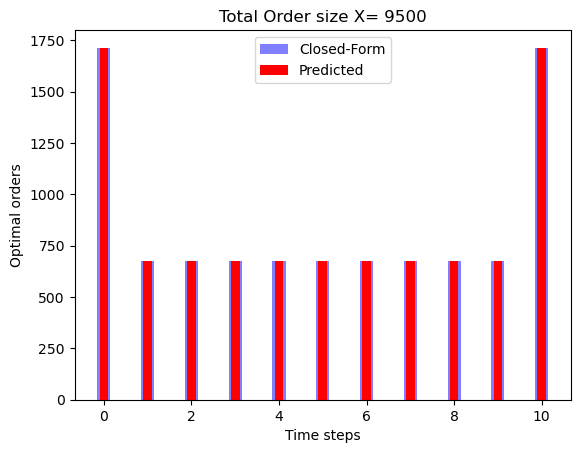

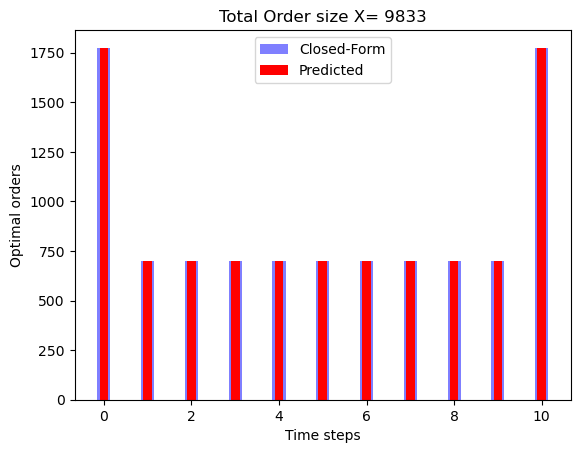

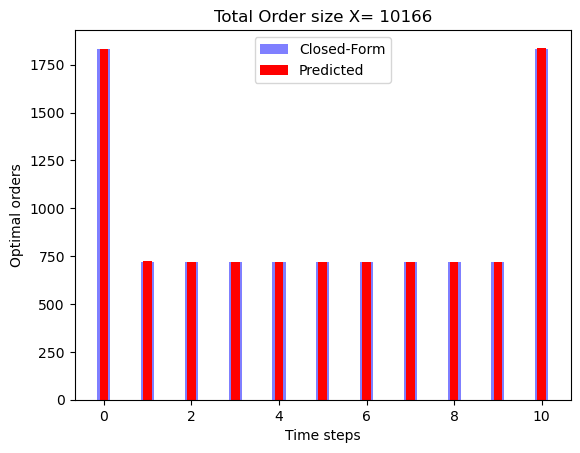

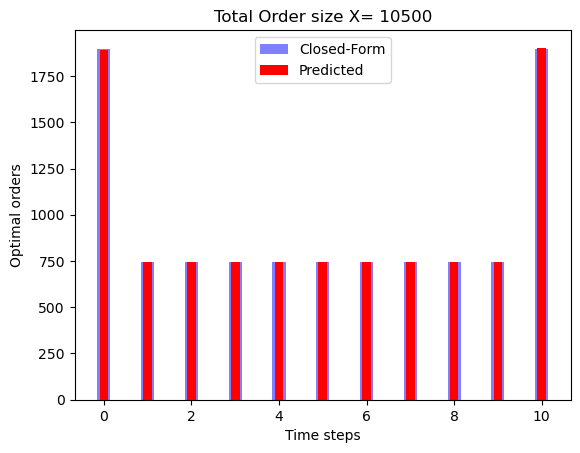

In [ ]:
p_soln=a.numpy()
t_step=np.linspace(0,ite,num=ite+1)
# name='/Users/shirinprovat/Desktop/Robin_Research/LOB_Linear/N_10_Linear.eps'
def plotting(t):
  #print('Total order size=',x1[t],np.sum(n_soln[t]),np.sum(p_soln[t]))
  #print(n_soln[t],p_soln[t])
  #plt.figure(figsize=(4,3))
  plt.bar(t_step,t_soln[t],color='blue',width=0.3,label='Closed-Form',alpha=0.5)
  plt.bar(t_step,p_soln[t],color='red',width=0.2,label='Predicted')
  #plt.bar(t_step,n_soln[t],color='green',width=0.1,label='numeric')
  plt.title('Total Order size X= %i' % (x1[t]))
  plt.xlabel('Time steps')
  plt.ylabel('Optimal orders')
  plt.legend()

  #plt.savefig('f.eps', format='eps')
#   if(t==0):
#     plt.savefig(name,format='eps')      
  plt.show()
for i in range(0,M1,3):
  plotting(i)


In [ ]:
#torch.save(model, 'model_N10_T1_K1_rho5_neo20.pth') 
#model_coarse = torch.load('model_N10.pth')

In [ ]:
# import json
# cost_numpy_list = [tensor.detach().item() for tensor in cost_ar]
# my_dic = {'Num_sample':M,'Time_step':ite,'T':T,'kappa':kappa,'Rho':rho,'Total_balance':X0,
#         'Num_neoron':neuron_model_psi,'Training_time':total_time,'epoch':max_epoch,
#           'accuracy':0.005*1/100,'Training_cost':cost_numpy_list}

# file_path=  'N10_T1_rho5_linear_dic.json'
# with open(file_path,'w') as file:
#     json.dump(my_dic,file)

Comparing solution at different time steps

In [ ]:
# #p_soln=a.numpy()
# t_step=np.linspace(0,ite,num=ite+1)
# X=R_test.squeeze(1).numpy()
# def plotting_time(t):
#   #print(t_soln[t],p_soln[t])
#   plt.figure(figsize=(4,3))
#   plt.plot(X,t_soln[:,0],color='blue',label='true')
#   plt.plot(X,p_soln[:,0],color='red',label='pred')
#   # plt.plot(X,n_soln[:,0],color='green',label='numeric')
#   plt.title('At time= %d' % (t_step[t]))
#   plt.xlabel('Total Order size')
#   plt.ylabel('Optimal orders')
#   plt.legend()
#   plt.show
# for i in range(0,t_step.shape[0],5):
#   plotting_time(i)


Absolute sum of the difference between true solution, predicted solution and true soln, numeric soln at each time step

In [ ]:
# sq_error=np.zeros(M1)
# sq_error_num=np.zeros(M1)

# for i in range(M1):
#   sq_error[i]=np.sum(np.abs(t_soln[i]-p_soln[i]))
#   sq_error_num[i]=np.sum(np.abs(t_soln[i]-n_soln[i]))
#   print(np.sum(t_soln[i]),'    ',sq_error[i])

# plt.figure(figsize=(4,2))
# plt.plot(X,sq_error,color='blue',label='pred')
# #plt.plot(X,sq_error_num,color='green',label='numeric')
# plt.title('Error with sample size= %d' % (M1))
# plt.xlabel('Total Order size')
# plt.ylabel('Sum of execution error')
# plt.legend()

Additional rough test

In [ ]:
# from torch.nn.modules.pooling import MaxPool1d
# M1=100
# t_test=torch.zeros([M1,1])
# D_test=torch.zeros([M1,1])
# #D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
# R_test=torch.linspace(50,100,100).unsqueeze(1)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
# x_test=torch.cat((t_test,D_test,R_test),dim=1)
# #print('Input=',x_test,'\n')
# soln=[]
# x_update = x_test
# #print(x_update)
# for i in range(ite+1):
#     #print(x_update)
#     soln_pred=model(x_update)
#     #print(soln_pred)
#     x_udpate=update(x_update,soln_pred.squeeze(1))
#     #print(x_update)
#     soln.append(soln_pred)
# strategy = torch.cat(soln,dim=1)
# print(strategy)
# # print('predicted soln=',strategy,'sum of all execution=',torch.sum(strategy,dim=1),'\n')
# a=[]
# b=[]
# c=[]
# for x in R_test:
#     a.append(x.numpy()[0])
#     y=closed_form(x.numpy()[0],ite+1)
#     #print(y)
#     b.append(y[0][0])
#     c.append(y[1])

In [ ]:
#model= torch.load('model_N10.pth')



In [ ]:
# from torch.nn.modules.pooling #model= torch.load('model_N10.pth')import MaxPool1d
# M1=20
# t_test=torch.zeros([M1,1])
# D_test=torch.zeros([M1,1])
# #D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
# #R_test=torch.FloatTensor(M1,1).uniform_(50,100)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
# R_test=torch.linspace(X0*0.95, X0*1.05, steps=M1).unsqueeze(1)
# x_test=torch.cat((t_test,D_test,R_test),dim=1)
# #print('Input=',x_test,'\n')
# a=torch.zeros(M1,ite+1)
# #print(a.shape)
# for i in range(ite+1):
#   if(i!=ite):
#     #print(x_test)
#     soln_pred=model(x_test).squeeze(1).detach()
#     a[:,i]=soln_pred
#     x_test=update(x_test,soln_pred)
#     #print(x_test,'\n')
#   else:
#     a[:,i]=R_test.squeeze(1)-torch.sum(a,dim=1)

# x1=R_test.squeeze().numpy()
# c_true=np.zeros(M1)
# c_pred=np.zeros(M1)
# c_num=np.zeros(M1)
# n_soln=np.zeros((M1,ite+1))
# t_soln=np.zeros((M1,ite+1))

# for i in range(M1):
#   print('size of total order=',x1[i])

#   t_soln[i,:]=closed_form(x1[i])
#   print('closed form soln=',t_soln[i,:],'sum of all execution=',np.sum(t_soln[i,:]))
#   true_cost=cost(t_soln[i,:])
#   c_true[i]=true_cost
#   print('Closed form cost=',true_cost,'\n')

#   print('predicted soln=',a[i,:],'sum of all execution=',torch.sum(a[i,:]).detach())
#   pred_cost=cost(a[i,:].detach().numpy())
#   print('predicted cost=',pred_cost,'\n')
#   c_pred[i]=pred_cost
#   print('Percent Error in cost=',np.abs(100*(true_cost-pred_cost)/true_cost),'%\n')
    
